In [1]:
import numpy as np
from astropy.io import ascii

import matplotlib.pyplot as plt
import matplotlib as mpl

In [2]:
import _pickle as cPickle
from matplotlib.path import Path

In [3]:
cat = np.genfromtxt('../catRawMags20Aug/catDir_SAGITTARIUS-II/sgCut_SAGITTARIUS-II_tcCut.dat',names=True)
xa = cat['xt1_f606w']
ya = cat['yt1_f606w']
flux_606 = cat['flux_f606w']

In [4]:
orientat = 83.644681506571
theta = np.deg2rad(orientat)
c,s = np.cos(theta), np.sin(theta)

In [5]:
#IMAGE BOUNDARY
IMAGE = Path([ [220,4045],
              [4218,4248],
              [4099,98],
              [0,0],
              [220,4045]])

In [6]:
xpath = np.array([220,4218,4099,0])
ypath = np.array([4045,4248,98,0])
xgap = np.array([100,99,4157,4156])
ygap = np.array([2033,2077,2233,2184])

x0 = 2386.25
y0 = 2224.53

x0T = c*(x0-x0) - s*(y0-(y0+500)) + x0
y0T = s*(x0-x0) + c*(y0-(y0+500)) + (y0+500)
xpT = c*(xpath-x0) - s*(ypath-(y0+500)) + x0
ypT = s*(xpath-x0) + c*(ypath-(y0+500)) + (y0+500)
xgT = c*(xgap-x0) - s*(ygap-(y0+500)) + x0
ygT = s*(xgap-x0) + c*(ygap-(y0+500)) + (y0+500)
xT = c*(xa-x0) - s*(ya-(y0+500)) + x0
yT = s*(xa-x0) + c*(ya-(y0+500)) + (y0+500)
xgood = xT
ygood = yT

In [7]:
def median_interval(data, alpha=0.32):
    """
    Median including Bayesian credible interval.

    Parameters
    ----------
    data  : posterior samples
    alpha : 1 - confidence interval

    Returns
    -------
    [med,[lo, hi]] : median, lower, and upper percentiles
    
    """
    q = [100*alpha/2., 50, 100*(1-alpha/2.)]
    lo,med,hi = np.percentile(data,q)
    return [med,[lo,hi]]

In [8]:
samples = cPickle.load( open( "sag2mcmc.p", "rb" ) )
#MEDIAN VALUES AND +/-1 SIGMA FOR EACH FIT PARAMETER
rich,[rich_min,rich_max] = median_interval(samples[:,0])
x,[xmin,xmax] = median_interval(samples[:,1])
y,[ymin,ymax] = median_interval(samples[:,2])
sag2_ext_fit,[sag2_ext_min,sag2_ext_max] = median_interval(samples[:,3])
sag2_ell_fit,[sag2_ell_min,sag2_ell_max] = median_interval(samples[:,4])
sag2_pa_fit,[sag2_pa_min,sag2_pa_max] = median_interval(samples[:,5])

res = [rich,rich_min,rich_max,x,xmin,xmax,y,ymin,ymax,sag2_ext_fit,sag2_ext_min,sag2_ext_max,\
       sag2_ell_fit,sag2_ell_min,sag2_ell_max,sag2_pa_fit,sag2_pa_min,sag2_pa_max]#,rich_cluster,rich_cluster_min,rich_cluster_max,x_cluster,x_cluster_min,x_cluster_max,y_cluster,y_cluster_min,y_cluster_max,cluster_ext_fit,cluster_ext_min,cluster_ext_max,cluster_ell_fit,cluster_ell_min,cluster_ell_max,cluster_pa_fit,cluster_pa_min,cluster_pa_max]
# results.append(res)

In [9]:
print(res)

[4887.172113219281, 4738.952339314343, 4969.567954505806, 3058.4099824621417, 2980.207458734817, 3137.3285941806903, 2783.446500601757, 2739.6100926636805, 2828.240557588124, 3361.465200409174, 3211.669845015338, 3506.2082988602097, 0.3509505657415931, 0.30428748993428434, 0.39363393395501833, 81.21586205366246, 80.31870185346054, 82.98433147138742]


In [10]:
# BEST-FIT sag2 I PARAMETERS (FROM MCMC_STRUCTURAL_FIT)
richness = rich
x0 = x
y0 = y
gal_ext_pix = sag2_ext_fit

gal_ell = sag2_ell_fit
gal_pa = sag2_pa_fit

In [11]:
xbin0 = np.ones((267,1))  # (fltarr(267)+1)
xbin1 = np.ones((1,267))  
xbin1[0] = np.arange(0,267,1)
xbin2 = xbin1 * 30 + 15  # (findgen(267)*30. + 15)
xbin = np.matmul(xbin0,xbin2)
ybin = xbin.T

# creating x and y arrays to represent the bins across the image

In [12]:
costh = np.cos(-1 * np.deg2rad(gal_pa))
sinth = np.sin(-1 * np.deg2rad(gal_pa))

dx = xbin - x0
dy = ybin - y0

In [13]:
r1 = (dx * costh - dy * sinth) / (1 - gal_ell)
r2 = (dx * sinth + dy * costh)

radius = np.sqrt(r1**2 + r2**2)
# calculating distances to different bins in the annuli based on the PA

In [14]:
r_h = gal_ext_pix
norm = r_h**2 / (np.pi * (1-gal_ell))
# half light radius squared / (pi * 1-ell)
pdf = norm/((radius**2 + r_h**2)**2)

In [15]:
xdel = 30.
ydel = 30.
pixarea = xdel*ydel  # pixel area in each bin

In [16]:
model_counts_gal = richness*pdf*pixarea  # a 267x267 array

In [17]:
# Observed surface density map
binned_surface_density_30 = np.zeros((267,267))
for ii in range(267):
    for jj in range(267):
        idxgood = np.logical_and(np.logical_and(xgood >= (30 * ii),xgood <= (30 * (ii + 1))),
                     np.logical_and(ygood >= (30 * jj),ygood <= (30 * (jj + 1))))

        tmp = np.where(idxgood)[0]
#         # flipping ii and jj because in IDL, it's col, row.
        binned_surface_density_30[jj,ii] = len(tmp)

In [18]:
# Define annuli
radius1=radius.flatten()
r1 = np.where(radius1 < (0.1 * r_h))
r2 = np.where((radius1 < (0.2 * r_h)) & (radius1 >= (0.1 * r_h)))
r3 = np.where((radius1 < (0.3 * r_h)) & (radius1 >= (0.2 * r_h)))
r4 = np.where((radius1 < (0.4 * r_h)) & (radius1 >= (0.3 * r_h)))
r5 = np.where((radius1 < (0.5 * r_h)) & (radius1 >= (0.4 * r_h)))
r6 = np.where((radius1 < (0.6 * r_h)) & (radius1 >= (0.5 * r_h)))
r7 = np.where((radius1 < (0.7 * r_h)) & (radius1 >= (0.6 * r_h)))
r8 = np.where((radius1 < (0.8 * r_h)) & (radius1 >= (0.7 * r_h)))
r9 = np.where((radius1 < (0.9 * r_h)) & (radius1 >= (0.8 * r_h)))
r10 = np.where((radius1 < r_h) & (radius1 >= (0.9 * r_h)))

In [19]:
# To get the actual indices
r1v = r1[0]
r2v = r2[0]
r3v = r3[0]
r4v = r4[0]
r5v = r5[0]
r6v = r6[0]
r7v = r7[0]
r8v = r8[0]
r9v = r9[0]
r10v = r10[0]

In [20]:
samples = cPickle.load( open( "sag2mcmcEXP.p", "rb" ) )
#MEDIAN VALUES AND +/-1 SIGMA FOR EACH FIT PARAMETER
rich2,[rich_min,rich_max] = median_interval(samples[:,0])
x2,[xmin,xmax] = median_interval(samples[:,1])
y2,[ymin,ymax] = median_interval(samples[:,2])
sag_ext_fit2,[sag_ext_min,sag_ext_max] = median_interval(samples[:,3])
sag_ell_fit2,[sag_ell_min,sag_ell_max] = median_interval(samples[:,4])
sag_pa_fit2,[sag_pa_min,sag_pa_max] = median_interval(samples[:,5])

res2 = [rich,rich_min,rich_max,x2,xmin,xmax,y2,ymin,ymax,sag_ext_fit2,sag_ext_min,sag_ext_max,\
       sag_ell_fit2,sag_ell_min,sag_ell_max,sag_pa_fit2,sag_pa_min,sag_pa_max]#,rich_cluster,rich_cluster_min,rich_cluster_max,x_cluster,x_cluster_min,x_cluster_max,y_cluster,y_cluster_min,y_cluster_max,cluster_ext_fit,cluster_ext_min,cluster_ext_max,cluster_ell_fit,cluster_ell_min,cluster_ell_max,cluster_pa_fit,cluster_pa_min,cluster_pa_max]
# results.append(res)

In [21]:
print(res2)

[4887.172113219281, 4785.452081400074, 4977.01262723177, 3058.276380953904, 2981.590247952599, 3134.6479139360827, 2783.7323504198766, 2739.9634355990643, 2827.1849804487206, 3441.2087307651473, 3294.2479100512082, 3586.164140630842, 0.37027950902271467, 0.3235623301143629, 0.4126145590912776, 81.1896772845635, 80.3128655070418, 82.93649344037703]


In [22]:
richness = rich2
x0 = x2
y0 = y2
gal_ext_pix = sag_ext_fit2
gal_ell = sag_ell_fit2
gal_pa = sag_pa_fit2
r_e = gal_ext_pix/1.68
r_h = gal_ext_pix

In [23]:
costh = np.cos(-1 * np.deg2rad(gal_pa))
sinth = np.sin(-1 * np.deg2rad(gal_pa))

dx = xbin - x0
dy = ybin - y0

In [24]:
richness = rich2
x0 = x2
y0 = y2
gal_ext_pix = sag_ext_fit2
gal_ell = sag_ell_fit2
gal_pa = sag_pa_fit2
r_e = gal_ext_pix/1.68
r_h = gal_ext_pix

In [25]:
r1 = (dx * costh - dy * sinth) / (1 - gal_ell)
r2 = (dx * sinth + dy * costh)

radius2 = np.sqrt(r1**2 + r2**2)
# calculating distances to different bins in the annuli based on the PA

In [26]:
sat_val = 75000

rad_dist = np.sqrt( (xa-x0)**2 + (ya-y0)**2)
sort_idx = np.argsort(rad_dist)
flat_flux = flux_606
flat_flux[flat_flux > sat_val] = 75000

sorted_rad = rad_dist[sort_idx]
sorted_flux = flat_flux[sort_idx]

total_flux = flat_flux.sum()

In [27]:
print(total_flux)
print(max(flat_flux))

21496988.015623763
75000.0


In [28]:
part_flux = 0
ii = 0

while part_flux <= (0.5*total_flux):
    part_flux += sorted_flux[ii]
    ii += 1
    
idx_take = ii - 1
rad_half = rad_dist[ii-1]

print(rad_half/1200)  # arcmin

1.168508132941305


In [29]:
#Normalization (integrates to unity over all space) [stars/pix^2)
norm2 = 1./(2*np.pi*r_e**2 * (1-gal_ell) )

# Exponential PDF
pdf2 = norm2 * np.exp(-radius2/r_e)

In [30]:
model_counts_exp = richness*pdf2*pixarea

In [31]:
# Define annuli
# Gives back list (or array?) of indices where the condition is true
# So... sources that are within a certain radius of the center
radius3=radius2.flatten()
r1 = np.where(radius3 < (0.1 * r_h))
r2 = np.where((radius3 < (0.2 * r_h)) & (radius3 >= (0.1 * r_h)))
r3 = np.where((radius3 < (0.3 * r_h)) & (radius3 >= (0.2 * r_h)))
r4 = np.where((radius3 < (0.4 * r_h)) & (radius3 >= (0.3 * r_h)))
r5 = np.where((radius3 < (0.5 * r_h)) & (radius3 >= (0.4 * r_h)))
r6 = np.where((radius3 < (0.6 * r_h)) & (radius3 >= (0.5 * r_h)))
r7 = np.where((radius3 < (0.7 * r_h)) & (radius3 >= (0.6 * r_h)))
r8 = np.where((radius3 < (0.8 * r_h)) & (radius3 >= (0.7 * r_h)))
r9 = np.where((radius3 < (0.9 * r_h)) & (radius3 >= (0.8 * r_h)))
r10 = np.where((radius3 < r_h) & (radius3 >= (0.9 * r_h)))

In [32]:
# To get the actual indices
r1ve = r1[0]
r2ve = r2[0]
r3ve = r3[0]
r4ve = r4[0]
r5ve = r5[0]
r6ve = r6[0]
r7ve = r7[0]
r8ve = r8[0]
r9ve = r9[0]
r10ve = r10[0]

In [33]:
# areas of annuli in arcmin**2
pix_per_arcsec=20

a1 = (np.pi*(r_h*0.1)**2*(1-gal_ell))/(pix_per_arcsec*60)**2
a2 = (np.pi*(r_h*0.2)**2*(1-gal_ell) - np.pi*(r_h*0.1)**2*(1-gal_ell))/(pix_per_arcsec*60)**2
a3 = (np.pi*(r_h*0.3)**2*(1-gal_ell) - np.pi*(r_h*0.2)**2*(1-gal_ell))/(pix_per_arcsec*60)**2
a4 = (np.pi*(r_h*0.4)**2*(1-gal_ell) - np.pi*(r_h*0.3)**2*(1-gal_ell))/(pix_per_arcsec*60)**2
a5 = (np.pi*(r_h*0.5)**2*(1-gal_ell) - np.pi*(r_h*0.4)**2*(1-gal_ell))/(pix_per_arcsec*60)**2
a6 = (np.pi*(r_h*0.6)**2*(1-gal_ell) - np.pi*(r_h*0.5)**2*(1-gal_ell))/(pix_per_arcsec*60)**2
a7 = (np.pi*(r_h*0.7)**2*(1-gal_ell) - np.pi*(r_h*0.6)**2*(1-gal_ell))/(pix_per_arcsec*60)**2
a8 = (np.pi*(r_h*0.8)**2*(1-gal_ell) - np.pi*(r_h*0.7)**2*(1-gal_ell))/(pix_per_arcsec*60)**2
a9 = (np.pi*(r_h*0.9)**2*(1-gal_ell) - np.pi*(r_h*0.8)**2*(1-gal_ell))/(pix_per_arcsec*60)**2
a10 = (np.pi*(r_h*1.0)**2*(1-gal_ell) - np.pi*(r_h*0.9)**2*(1-gal_ell))/(pix_per_arcsec*60)**2

In [34]:
dist_x = np.array([r_h*0.1,r_h*0.2,r_h*0.3,r_h*0.4,r_h*0.5,r_h*0.6,r_h*0.7,r_h*0.8,r_h*0.9,r_h])/1200

In [35]:
binned_surface_density_30f = binned_surface_density_30.flatten()
model_counts_galf = model_counts_gal.flatten()
model_counts_expf = model_counts_exp.flatten()
data_1d = [binned_surface_density_30f[r1v].sum()/a1,
           binned_surface_density_30f[r2v].sum()/a2,
           binned_surface_density_30f[r3v].sum()/a3,
           binned_surface_density_30f[r4v].sum()/a4,
           binned_surface_density_30f[r5v].sum()/a5,
           binned_surface_density_30f[r6v].sum()/a6,
           binned_surface_density_30f[r7v].sum()/a7,
           binned_surface_density_30f[r8v].sum()/a8,
           binned_surface_density_30f[r9v].sum()/a9,
           binned_surface_density_30f[r10v].sum()/a10]

model_1d = [model_counts_galf[r1v].sum()/a1,
            model_counts_galf[r2v].sum()/a2,
            model_counts_galf[r3v].sum()/a3,
            model_counts_galf[r4v].sum()/a4,
            model_counts_galf[r5v].sum()/a5,
            model_counts_galf[r6v].sum()/a6,
            model_counts_galf[r7v].sum()/a7,
            model_counts_galf[r8v].sum()/a8,
            model_counts_galf[r9v].sum()/a9,
            model_counts_galf[r10v].sum()/a10]

model_1de = [model_counts_expf[r1ve].sum()/a1,
            model_counts_expf[r2ve].sum()/a2,
            model_counts_expf[r3ve].sum()/a3,
            model_counts_expf[r4ve].sum()/a4,
            model_counts_expf[r5ve].sum()/a5,
            model_counts_expf[r6ve].sum()/a6,
            model_counts_expf[r7ve].sum()/a7,
            model_counts_expf[r8ve].sum()/a8,
            model_counts_expf[r9ve].sum()/a9,
            model_counts_expf[r10ve].sum()/a10]

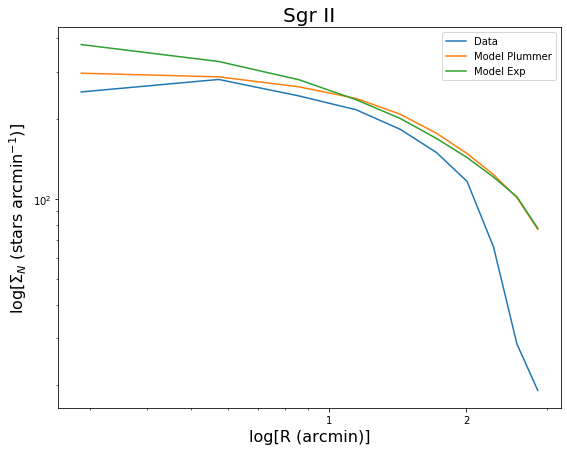

In [36]:
fig, ax = plt.subplots(figsize=(9,7))

ax.plot(dist_x,data_1d,label='Data')
ax.plot(dist_x,model_1d,label='Model Plummer')
ax.plot(dist_x,model_1de,label='Model Exp')

ax.set_xscale('log')
ax.set_yscale('log')

ax.set_ylabel(r'log[$\Sigma_N$ (stars arcmin$^{-1}$)]',fontsize=16)
ax.set_xlabel(r'log[R (arcmin)]',fontsize=16)
ax.set_title('Sgr II',fontsize=20)

ax.set_xticks([1, 2])
ax.get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())



ax.legend()
# plt.savefig('figures/sgr2.png')
plt.show()

In [37]:
ra1 = np.arange(0,10,1)
r_annuli = (ra1 + 0.05) * r_h

binned_surface_density_30f = binned_surface_density_30.flatten()
model_counts_expf = model_counts_exp.flatten()
model_counts_galf = model_counts_gal.flatten()
data_1d = [binned_surface_density_30f[r1v].sum(),
           binned_surface_density_30f[r2v].sum(),
           binned_surface_density_30f[r3v].sum(),
           binned_surface_density_30f[r4v].sum(),
           binned_surface_density_30f[r5v].sum(),
           binned_surface_density_30f[r6v].sum(),
           binned_surface_density_30f[r7v].sum(),
           binned_surface_density_30f[r8v].sum(),
           binned_surface_density_30f[r9v].sum(),
           binned_surface_density_30f[r10v].sum()]

model_1d = [model_counts_galf[r1v].sum(),
            model_counts_galf[r2v].sum(),
            model_counts_galf[r3v].sum(),
            model_counts_galf[r4v].sum(),
            model_counts_galf[r5v].sum(),
            model_counts_galf[r6v].sum(),
            model_counts_galf[r7v].sum(),
            model_counts_galf[r8v].sum(),
            model_counts_galf[r9v].sum(),
            model_counts_galf[r10v].sum()]

model_1de = [model_counts_expf[r1ve].sum(),
            model_counts_expf[r2ve].sum(),
            model_counts_expf[r3ve].sum(),
            model_counts_expf[r4ve].sum(),
            model_counts_expf[r5ve].sum(),
            model_counts_expf[r6ve].sum(),
            model_counts_expf[r7ve].sum(),
            model_counts_expf[r8ve].sum(),
            model_counts_expf[r9ve].sum(),
            model_counts_expf[r10ve].sum()]

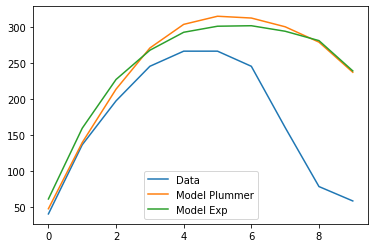

In [38]:
fig, ax = plt.subplots()

ax.plot(ra1,data_1d,label='Data')
ax.plot(ra1,model_1d,label='Model Plummer')
ax.plot(ra1,model_1de,label='Model Exp')

ax.legend()
plt.show()

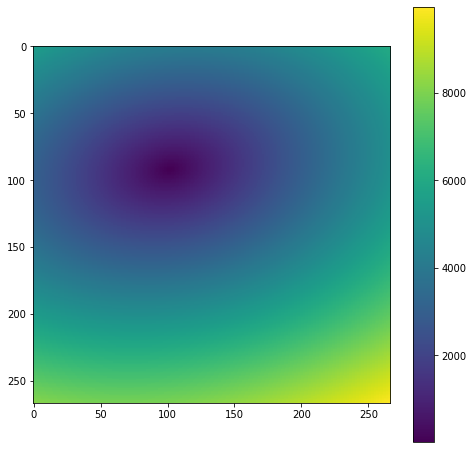

In [39]:
fig,ax = plt.subplots(figsize=(8,8))

plt.imshow(radius)
plt.colorbar()

In [ ]:
# Exponential radius (re = rh/1.68)
r_e = ext/1.68 
#Normalization (integrates to unity over all space) [stars/pix^2)
norm = 1./(2*np.pi*r_e**2 * (1-ell) )

# Exponential PDF
pdf = norm * np.exp(-radius/r_e)